<a href="https://colab.research.google.com/github/luiscunhacsc/udemy-ai-en/blob/main/part2_time_series/part2_example01_stock_market_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keras 3 version

---
# **Predicting stock market index using LSTM (N-day window)**

**Disclaimer**: Originally based on work by Hum Nath Bhandari, Binod Rimal, Nawa Raj Pokhrel, Ramchandra Rimal, Keshav Dahal, and Rajendra K.C. Khatri

**Reference**: Bhandari, H. N., Rimal, B., Pokhrel, N. R., Rimal, R., Dahal, K., & K C Khatri, R. (2022). Predicting stock market index using LSTM. Machine Learning with Applications, 9, 100320. https://doi.org/10.1016/j.mlwa.2022.100320

---

## **Introduction**

In this module we use various financial resources to create input data for our machine learning models. This includes the following data.
- S\&P 500 index data: Close price
- Vix index
- Interest Rate
- Unemployment Rate
- Consumer sentiment index
- Dollar Index
- MACD
- RSI
- ATR

#### **0. Define the number of days in the series**

In [15]:
# Number of days in the sequence (e.g. 5, 21, 90)
Nd=21

#### **1. Importing basic libraries and APIs**

In [16]:
# Installing seaborn (for prettier plots)
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:

# Mathematical library
import math

# Data manipulation libraries
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Utility libraries
import warnings
warnings.filterwarnings('ignore')
import os
import datetime as dt


#### **1. Data Loading and Verification**

##### **1.1 Loading input data**



In [18]:
url = 'https://raw.githubusercontent.com/luiscunhacsc/course_dl_datasets/main/sp500_data.csv'
data = pd.read_csv(url)

data['Date']=pd.to_datetime(data['Date']).dt.date
data.set_index("Date",inplace=True)
data = data.iloc[:, 1:]



##### **1.2 Data Exploration**

In [19]:
# Textual verification of the data
data.head()


,Close,MACD,RSI,ATR,VIX,USDX,EFFR,UNRATE,UMCSENT
Date,,,,,,,,,
1990-01-02,359.690002,1.961022,70.413375,3.395178,17.240000,94.290001,8.54,5.4,90.5
1990-01-03,358.760010,2.502839,68.197007,3.345014,18.190001,94.419998,8.37,5.4,90.5
1990-01-04,355.670013,2.652321,61.293578,3.527078,19.219999,92.519997,8.29,5.4,90.5
1990-01-05,352.200012,2.462401,54.608367,3.584214,20.110001,92.849998,8.20,5.4,90.5
1990-01-08,353.790009,2.412380,56.926617,3.592551,20.260000,92.050003,8.27,5.4,90.5


In [20]:
# Textual verification of the data
data.tail()

,Close,MACD,RSI,ATR,VIX,USDX,EFFR,UNRATE,UMCSENT
Date,,,,,,,,,
2024-04-19,4967.229980,-31.185359,31.291564,58.287082,18.709999,106.150002,5.33,3.8,79.4
2024-04-22,5010.600098,-35.113118,37.897454,59.238710,16.940001,106.080002,5.33,3.8,79.4
2024-04-23,5070.549805,-33.007959,45.672800,59.687375,15.690000,105.690002,5.33,3.8,79.4
2024-04-24,5071.629883,-30.896300,45.804452,58.456845,15.970000,105.860001,5.33,3.8,79.4
2024-04-25,5048.419922,-30.741278,43.372114,60.070628,15.370000,105.599998,5.33,3.8,79.4


In [21]:
# Textual verification of the data
print(data.shape)
data.describe()

(8645, 9)


,Close,MACD,RSI,ATR,VIX,USDX,EFFR,UNRATE,UMCSENT
count,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000
mean,1615.715481,3.870106,54.263460,20.796954,19.534596,92.013446,2.807902,5.745240,85.310226
std,1133.437047,21.757831,11.355262,18.550949,7.889294,10.056460,2.378720,1.754193,13.075943
min,295.459991,-237.020227,13.639346,2.402838,9.140000,71.330002,0.040000,3.500000,50.000000
25%,900.940002,-2.699066,46.159839,10.008013,13.840000,84.070000,0.200000,4.400000,76.000000
50%,1272.880005,3.686556,55.081469,15.777488,17.690001,91.980003,2.370000,5.400000,88.300000
75%,2068.590088,13.063146,62.574150,25.097585,22.910000,98.040001,5.210000,6.700000,95.100000
max,5254.350098,92.583711,86.686650,152.756467,82.690002,120.900002,10.390000,14.800000,111.300000


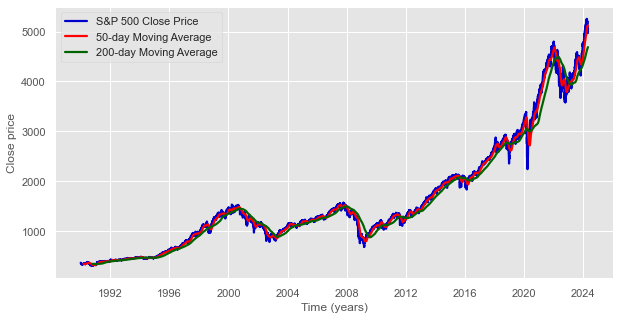

In [22]:
# Graphical verification of the data
df = data.copy()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_200'] = df['Close'].rolling(200).mean()

fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(df['Close'], 'mediumblue',label=['S&P 500 Close Price'], linewidth = 2.2)
plt.plot(df['MA_50'],'red', label=['50-day MA'], linewidth = 2.2)
plt.plot(df['MA_200'],'darkgreen', label=['200-day MA'], linewidth = 2.2)
plt.legend(['S&P 500 Close Price', '50-day Moving Average', '200-day Moving Average'], loc='upper left')
plt.title('')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
#fig.savefig(output_dir_path+ "original_data_plus_moving_averages.png",dpi=600)
plt.show()

#####  **1.3 Correlation heatmap**

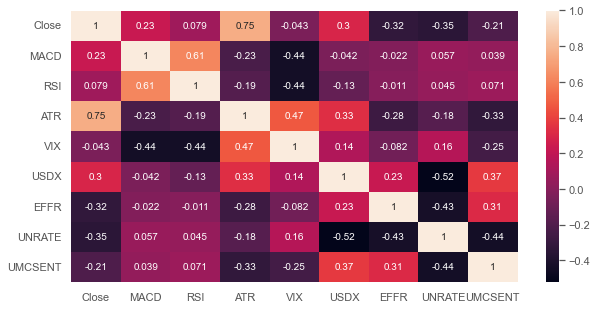

In [23]:
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
#fig.savefig(output_dir_path+"correlation_heatmap2.png",dpi=600)
plt.show()

<Figure size 1440x864 with 0 Axes>

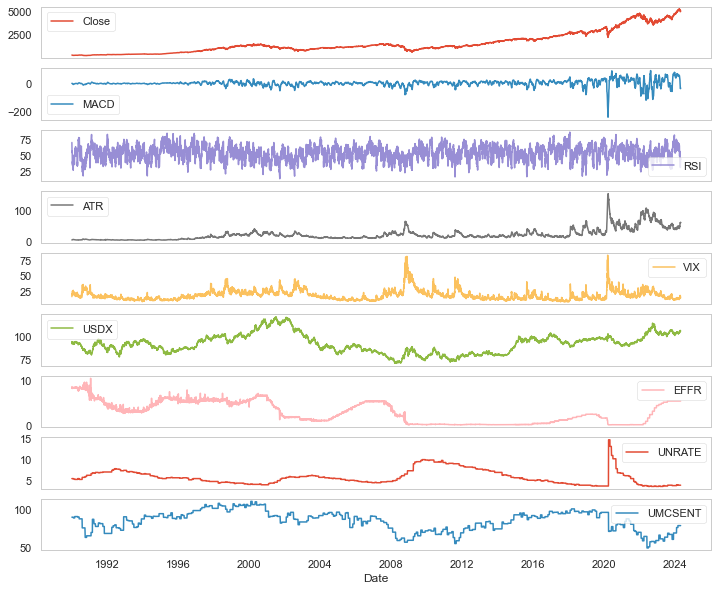

In [24]:
fig = plt.figure(figsize = (20, 12))
data.plot(subplots = True, figsize = (12,10),grid=False)
sns.set_style("whitegrid")
#fig.savefig(output_dir_path+"timeseries.png",dpi=600)
plt.show()

#### **2. Prepare the data for the LSTM model - don't forget to set number of days (Nd) in step 0, above**

In [25]:

# Store date information for plotting
dates = data.index

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define a function to create sequences of input data and labels
def create_sequences(data, sequence_length, target_column):
    x, y = [], []
    for i in range(len(data) - sequence_length - 1):
        x.append(data[i: i + sequence_length])
        y.append(data[i + sequence_length, target_column])
    return np.array(x), np.array(y)

# Create input sequences and labels
sequence_length = Nd  # Nd is the number of days in the sequence, to predict next day's (Nd+1) closing price   <--- "Nd" defined at the beginning of the script (step 0)
target_column = 0  # Assuming 'Close' is the first column in the dataset
x, y = create_sequences(data_scaled, sequence_length, target_column)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, shuffle=False)


#### **3. Define the LSTM model**

In [26]:
input_layer = Input(shape=(sequence_length, data.shape[1]))
lstm_layer = LSTM(150)(input_layer)
output_layer = Dense(1)(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

#### **4. Compile and train the model**

In [27]:
#optimizer = Adam(learning_rate=0.001)
#optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer="adam", loss="mean_squared_error")

batch_size = 8
epochs = 50  # Adjust the number of epochs according to your needs
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
853/853 [==============================] - 12s 12ms/step - loss: 4.7811e-04
Epoch 2/50
853/853 [==============================] - 10s 12ms/step - loss: 4.0178e-05
Epoch 3/50
853/853 [==============================] - 10s 12ms/step - loss: 3.2453e-05
Epoch 4/50
853/853 [==============================] - 10s 12ms/step - loss: 3.5749e-05
Epoch 5/50
853/853 [==============================] - 10s 12ms/step - loss: 2.9544e-05
Epoch 6/50
853/853 [==============================] - 10s 12ms/step - loss: 2.3198e-05
Epoch 7/50
853/853 [==============================] - 10s 12ms/step - loss: 2.2980e-05
Epoch 8/50
853/853 [==============================] - 10s 12ms/step - loss: 2.1853e-05
Epoch 9/50
853/853 [==============================] - 10s 12ms/step - loss: 2.1027e-05
Epoch 10/50
853/853 [==============================] - 10s 12ms/step - loss: 2.0712e-05
Epoch 11/50
853/853 [==============================] - 10s 12ms/step - loss: 1.8291e-05
Epoch 12/50
853/853 [====================

#### **5. Make predictions using the trained model**

In [28]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

#### **6. Trasform data back to original scale**

In [29]:
# Inverse-transform the scaled data back to the original scale
y_train_true = scaler.inverse_transform(np.hstack(
    (y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1)))))
y_test_true = scaler.inverse_transform(np.hstack(
    (y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1)))))
y_train_pred = scaler.inverse_transform(np.hstack(
    (y_train_pred, np.zeros((y_train_pred.shape[0], data.shape[1] - 1)))))
y_test_pred = scaler.inverse_transform(
    np.hstack((y_test_pred, np.zeros((y_test_pred.shape[0], data.shape[1] - 1)))))




#### **7. Plot *all* the historical data, including predictions at the end**

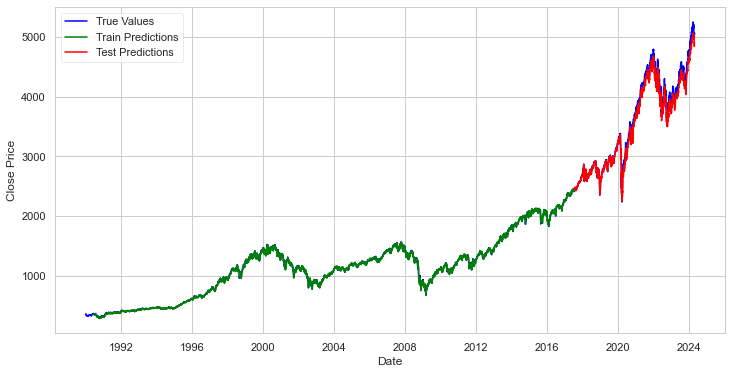

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(dates, data['Close'], label='True Values', color='blue')
plt.plot(dates[sequence_length:len(y_train) + sequence_length],
         y_train_pred[:, 0], label='Train Predictions', color='green')
plt.plot(dates[len(y_train) + sequence_length:len(y_train) + len(y_test) +
         sequence_length], y_test_pred[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


#### **8. Plot *only* the end of the series, containing the predictions**

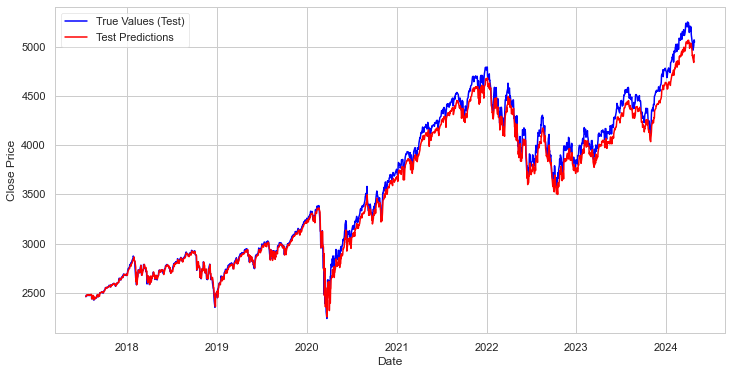

In [31]:
# Plot only the true values and test predictions
plt.figure(figsize=(12, 6))
plt.plot(dates[len(y_train) + sequence_length:], data['Close'][len(y_train) + sequence_length:], label='True Values (Test)', color='blue')
plt.plot(dates[len(y_train) + sequence_length:len(y_train) + len(y_test) + sequence_length], y_test_pred[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
